# Para casa: rodando os exemplos no FPGA __(por favor, não façam durante o curso!)__

O _script_ a seguir irá preparar o ambiente para coletarmos dados de execução e plotarmos gráficos com eles. Ele precisa ser executado inicialmente uma única vez. O arquivo `hough.csv` já contem dados de execuções anteriores, mas você pode apagá-los e fazer os seus próprios experimentos se desejar. 

In [2]:
import os
import platform
import subprocess
import pandas as pd
import numpy

RUNS = 10

FILENAME = 'hough.csv'

if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"versão": [], "plataforma": [], "tempo_de_execução_s": []})

df.groupby(['plataforma', 'versão']) \
  .agg({'versão':'count', 'tempo_de_execução_s':'mean'}) \
  .rename(columns={'versão':'count','versão':'execuções'})

execuções  \
plataforma                        versão                     
 Intel PAC Platform (pac_ee00000)  banking              10   
                                   local_memory         10   
                                   original             10   
                                   unroll               10   

                                                 tempo_de_execução_s  
plataforma                        versão                              
 Intel PAC Platform (pac_ee00000)  banking                  0.005577  
                                   local_memory             0.061376  
                                   original                 2.870380  
                                   unroll                   0.018581

As etapas seguintes (__A.__, __B.__ e __C.__) precisam ser repetidas para cada versão do código (`original`, `local_memory`, `unroll` e `banking`). O local das modificações é indicado a cada etapa.  

## A. Compilando para FPGAs

A etapa de compilação para FPGAs só deve ser realizada depois de termos certeza de que nosso código está correto e que terá o desempenho desejado. Como vimos no curso, isso pode ser feito a partir da emulação e análise dos relatórios. 

O comando (`qsub`) a seguir serve para submeter o script de compilação na fila (__cuidado para não fazer isso mais de uma vez, pois deve demorar horas!__), ele retorna um __id__ (e.g. `691653.v-qsvr-1.aidevcloud`) que pode ser usado para acompanhar o processo. Na célula seguinte podemos acompanhar o processo com o comando `qstat`. Caso queira cancelar o job, use o comando `qdel` seguido de seu __id__ (troque-o na célula logo abaixo). Cada versão do código está em uma pasta diferente, então basta indicar a pasta desejada após a flag `-d` para compilar as diferentes versões do código. 

>Para evitar que você faça isso por engano durante o curso, eu coloquei uma `#` antes do comando, retire-a quando for realmente executar. Tem mais um detalhe, mas eu tenho certeza de que você descobrirá por conta própria depois ;-) 

In [3]:
!#qsub -l nodes=1:fpga_conpile:ppn=2 -d original fpga_compile.sh

692240.v-qsvr-1.aidevcloud


In [5]:
! qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
692238.v-qsvr-1            ...ub-singleuser u44807          00:00:08 R jupyterhub     
692240.v-qsvr-1            fpga_compile.sh  u44807          00:06:55 R batch          


In [13]:
! qdel 692240.v-qsvr-1.aidevcloud

qdel: nonexistent job id: 691653.v-qsvr-1.aidevcloud


## B. Rodando seu código no FPGA

Após uma longa espera, o compilador deve ter gerado o código específico para rodar no FPGA (`hough_transform.fpga`), agora é hora de executá-lo!

O _script_ abaixo submete 10 vezes o código gerado para execução em nós com FPGAs e só precisa ser invocado uma única vez para cada versão do código. As execuções podem ocorrer em paralelo e nós diferentes, de acordo com a disponibilidade do sistema. Você pode acompanhar com o comando `qstat` na célula logo abaixo, ou digitar `watch qstat` em um terminal (eu não disse isso antes, pois esperar a compilação olhando para a tela pode causar sérios problemas :-P). Cada versão do código está em uma pasta diferente, então basta indicar a pasta desejada após a flag `-d` para rodar as diferentes versões do código.

In [46]:
! for i in {1..10}; do qsub -l nodes=1:fpga_runtime:ppn=2 -d original fpga_run.sh; done

692344.v-qsvr-1.aidevcloud
692345.v-qsvr-1.aidevcloud
692346.v-qsvr-1.aidevcloud
692347.v-qsvr-1.aidevcloud
692348.v-qsvr-1.aidevcloud
692349.v-qsvr-1.aidevcloud
692350.v-qsvr-1.aidevcloud
692351.v-qsvr-1.aidevcloud
692352.v-qsvr-1.aidevcloud
692353.v-qsvr-1.aidevcloud


In [49]:
! qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
692238.v-qsvr-1            ...ub-singleuser u44807          00:03:24 R jupyterhub     
692347.v-qsvr-1            fpga_run.sh      u44807                 0 R batch          
692348.v-qsvr-1            fpga_run.sh      u44807                 0 R batch          
692349.v-qsvr-1            fpga_run.sh      u44807                 0 R batch          
692350.v-qsvr-1            fpga_run.sh      u44807                 0 Q batch          
692351.v-qsvr-1            fpga_run.sh      u44807                 0 Q batch          
692352.v-qsvr-1            fpga_run.sh      u44807                 0 Q batch          
692353.v-qsvr-1            fpga_run.sh      u44807                 0 Q batch          


## C. Coletando os dados

Comparada à compilação, a execução é quase instantânea, não é mesmo? 

Cada _job_ enviado para execução, gera um arquivo da saída padrão (`stdout`) e outro com possíveis erros (`stderr`). Para cada versão do código, certifique-se de que os arquivos de erro estão vazios antes de prosseguir com a coleta dos dados. Se o comando a seguir não retornar nada, está tudo certo! Se algum erro aparecer, certifique-se de apagar os arquivos das execuções problematicas e disparar novas para substituí-las. Eles podem ocorrer, por exemplo, se um nó que deveria ter um FPGA não conseguir acessá-lo no momento da execução. 

__Não esqueça de modificar o nome da pasta a cada versão do código.__

In [50]:
! cat original/*.e*

O comando abaixo irá pegar as saídas das execuções, filtrar as linhas desejadas, separar o tempo de execução e colocar no nosso arquivo de dados. Você só precisa executá-lo uma única vez para cada versão do código. Como ele não apaga as saídas, novas execuções dele irão adicionar os mesmos dados no final do arquivo. Se isso acontecer, basta abrir o arquivo de dados e apagar as linhas excedentes. 

__Note que você precisa alterá-lo em dois locais: (i) após o comando `cd` que muda a pasta para a versão desejada; (ii) ao final das aspas duplas, dentro das chaves do comando `awk`, indicando qual a versão.__ 

In [33]:
! cd original; cat fpga_run.sh.o* | grep seconds | awk '{ print $4 ", Intel PAC Platform (pac_ee00000), original" }' >> ../hough.csv

Text(0, 0.5, 'Tempo de execução (s)')

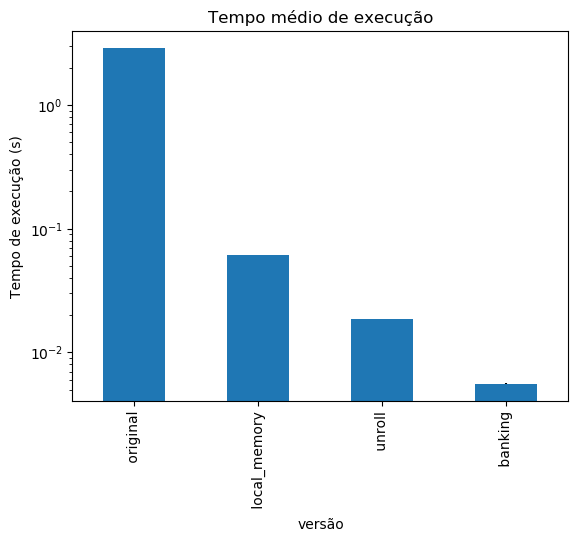

In [3]:
df = pd.read_csv(FILENAME)
by_version = df.groupby(by="versão", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", log=True, yerr=std)
plt.set_title("Tempo médio de execução")
plt.set_ylabel("Tempo de execução (s)")

,ALUTs,Registers,Logic utilization,DSP blocks,RAM blocks,plataforma,versão
0,73637,121335,85568,2,517,Intel PAC Platform (pac_ee00000),original
1,83639,128218,95273,2,537,Intel PAC Platform (pac_ee00000),local_memory
2,133770,172310,127001,64,1030,Intel PAC Platform (pac_ee00000),unroll
3,115876,159260,115789,64,1125,Intel PAC Platform (pac_ee00000),banking


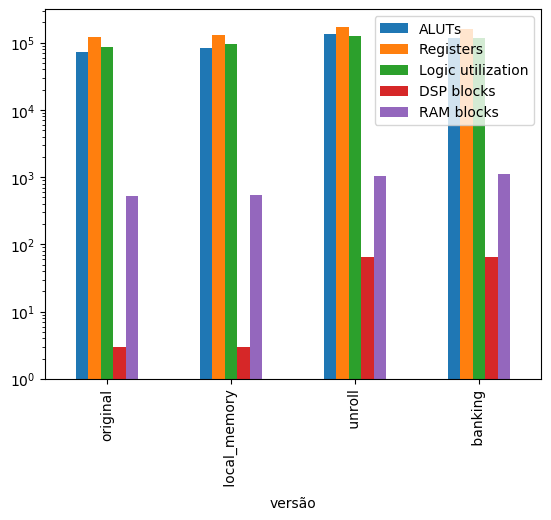

In [4]:
df = pd.read_csv('resources.csv')
by_version = df.groupby(by="versão", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=True, kind="bar", log=True, yerr=std)
df